# Databases, Data Visualizaion, & Data Exploration

## Import Dependencies

In [63]:
# A Jupyter Notebook magic command that enables the rendering of Matplotlib plots directly within the notebook interface.
%matplotlib inline
!pip install sqlalchemy # Use the pip package manager to install the "sqlalchemy" Python library.

import pandas as pd # A library for data manipulation and analysis.
import numpy as np # A library for numerical computing in Python.
import os #  Alibrary module for operating system-related functions.
import matplotlib.pyplot as plt # provides a collection of functions that allow you to create and customize plots.
from matplotlib import style # provides various predefined styles for customizing the appearance of plots.
style.use('fivethirtyeight') # emulates the visual style of the plots often seen on the (https://fivethirtyeight.com/) website.
from datetime import datetime as dt, timedelta # A module rom the Python Standard Library that provides classes for manipulating dates and times in Python.
import sqlalchemy # A library module used to access a SQL database from Python and provides the core functinality for working with databases, including the Object Relational Mapper.
from sqlalchemy.ext.automap import automap_base # A function that creates a new base class for declarative class definitions. It is used to reflect database tables into Python classes.
from sqlalchemy.orm import Session # A class that represents a database session and provides an interface for interacting with the database.
from sqlalchemy import create_engine, func # Functions for creating a database engine and using SQL functions in queries, respectively.
from sqlalchemy import text # Imports the text function from SQLAlchemy for raw SQL execution.
from sqlalchemy import Integer # SQLAlchemy data type for integer values.

## Reflect Tables into SQLAlchemy ORM
- In SQLAlchemy, "reflecting tables" refers to the process of automatically creating Python classes that correspond to existing database tables. This process allows you to use Object-Relational Mapping (ORM) techniques to interact with database tables using Python objects and methods, providing a more intuitive and object-oriented way to work with database data.
- When you reflect tables in SQLAlchemy, you're essentially generating Python class definitions that mirror the structure of the database tables. These generated classes are known as "table classes." Each table class represents a table in the database and provides a convenient way to perform database operations without writing raw SQL queries.

__Source:__ “What does it mean to reflect tables into SQLAlchemy ORM?” prompt. _ChatGPT_, 20 Aug. version, OpenAI, 20 Aug. 2023, chat.openai.com/chat.

In [64]:
# Provide the absolute file path to hawaii.sqlite
database_path = "../database/hawaii.sqlite"

# create engine to hawaii.sqlite
engine = create_engine(f"sqlite:///{database_path}")

### Read CSVs to SQLite database

In [65]:
# Specify the path to the database
path_database = '../database/hawaii.sqlite'

# Check if the database file exists and delete it if it does
if os.path.exists(path_database):
    os.remove(path_database)
    print("Existing database file deleted.")

# Read CSV data into a DataFrame
path_csv_file_1 = '../data/hawaii_measurements.csv'
path_csv_file_2 = '../data/hawaii_stations.csv'
dataframe_1 = pd.read_csv(path_csv_file_1)
dataframe_2 = pd.read_csv(path_csv_file_2)

# Add primary key column 'id' to DataFrames
dataframe_1.insert(0, 'id', range(1, 1 + len(dataframe_1)))
dataframe_2.insert(0, 'id', range(1, 1 + len(dataframe_2)))

# Create a database engine
database_url = f'sqlite:///{path_database}'
engine = create_engine(database_url)

# Create new tables with primary keys
table_name_1 = 'measurement'
table_name_2 = 'station'

# Create schema for the new tables
schema_1 = f"CREATE TABLE {table_name_1} (id INTEGER PRIMARY KEY, {', '.join(dataframe_1.columns[1:])});"
schema_2 = f"CREATE TABLE {table_name_2} (id INTEGER PRIMARY KEY, {', '.join(dataframe_2.columns[1:])});"

# Execute the schema creation
with engine.connect() as connection:
    connection.execute(text(schema_1))
    connection.execute(text(schema_2))

# Insert data from DataFrame into the new tables
dataframe_1.to_sql(table_name_1, engine, index=False, if_exists='append')
dataframe_2.to_sql(table_name_2, engine, index=False, if_exists='append')

print("CSV data has been imported to the SQLite database.")

Existing database file deleted.
CSV data has been imported to the SQLite database.


In [66]:
# Reflect an existing database into a new model
Base = automap_base()

# Reflect the tables using the engine for autoload
Base.prepare(autoload_with=engine)

# View all of the classes that automap found
classes = Base.classes

# Check if classes are empty
print("Classes:", Base.classes)

# Get the table names
table_names = Base.classes.keys()

# Print the table names
print("Table Names:", table_names)

Classes: <sqlalchemy.util._collections.Properties object at 0x7fbdf8f48a30>
Table Names: ['measurement', 'station']


In [67]:
# View all of the classes that automap found
classes = Base.classes

# Get the table names
table_names = classes.keys()

# Print the table names
for table_name in table_names:
    print(table_name)

measurement
station


In [68]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [69]:
# Creates the session (link) from Python to the DB
session = Session(engine)

# Uses a query to retrieve data and stores it in a list datatype object
measurement_results = session.query(Measurement).all()

# Converts the returned data to a dataframe datatype object
df_measurement = pd.DataFrame([{'prcp': r.prcp, 'id': r.id, 'station': r.station, 'date': r.date, 'tobs': r.tobs} for r in measurement_results])

# displays the dataframe
df_measurement

,prcp,id,station,date,tobs
0,0.08,1,USC00519397,2010-01-01,65
1,0.00,2,USC00519397,2010-01-02,63
2,0.00,3,USC00519397,2010-01-03,74
3,0.00,4,USC00519397,2010-01-04,76
4,NaN,5,USC00519397,2010-01-06,73
...,...,...,...,...,...
19545,0.09,19546,USC00516128,2017-08-19,71
19546,NaN,19547,USC00516128,2017-08-20,78
19547,0.56,19548,USC00516128,2017-08-21,76
19548,0.50,19549,USC00516128,2017-08-22,76


# Exploratory Precipitation Analysis

In [70]:
# Find the most recent date in the data set.
# Convert df.date column to datetime type
df_measurement['date'] = pd.to_datetime(df_measurement['date'])

# Find the most recent date in the data set
most_recent_date = session.query(func.max(Measurement.date)).scalar()

# Print the most recent date
print(most_recent_date)

2017-08-23


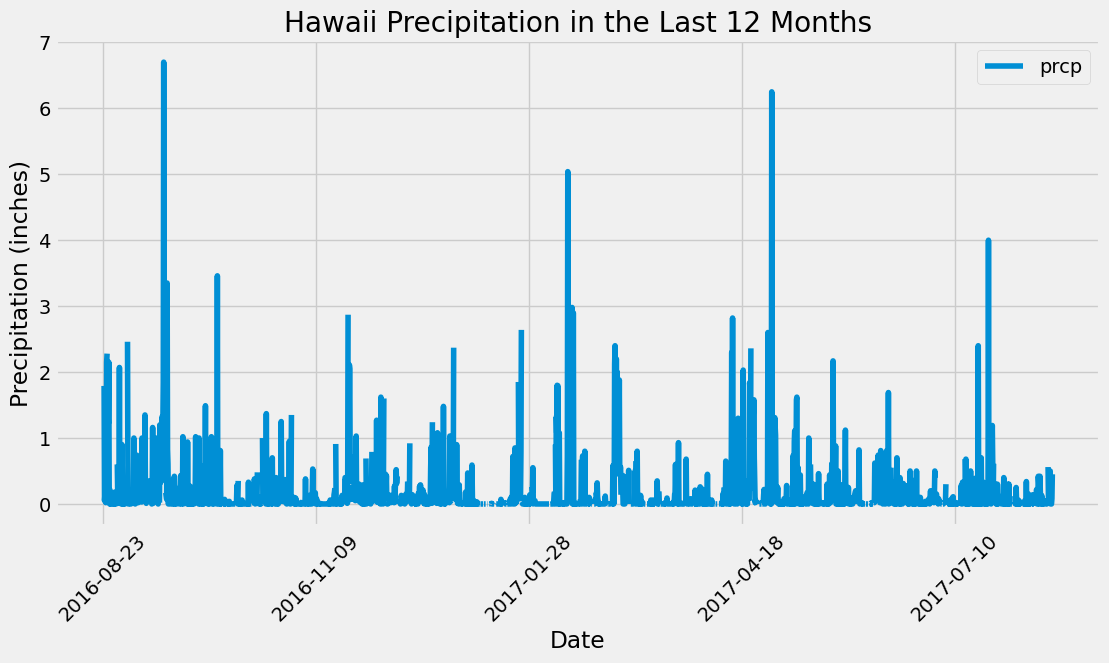

In [71]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Convert the most_recent_date object datatype from String to DateTime
most_recent_date = pd.to_datetime(most_recent_date)

# Calculate the date one year from the last date in the dataset.
one_year_ago = most_recent_date - pd.DateOffset(years=1)

# Creates a new variable, one_year_ago_str, with datatype = string based on the one_year_ago variable with datatype DateTime.
one_year_ago_str = one_year_ago.strftime('%Y-%m-%d')

# Performs a query to retrieve the date and precipitation scores
precipitation_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago_str).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df_precipitation = pd.DataFrame(precipitation_results, columns=['date', 'prcp'])
df_precipitation.set_index('date', inplace=True)

# Sorts the dataframe by date
df_precipitation.sort_index(inplace=True)

#  Pandas Plotting with Matplotlib used to plot the data
df_precipitation.plot(y='prcp', figsize=(12, 6))
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.title('Hawaii Precipitation in the Last 12 Months')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()


In [72]:
# Convert query results to a DataFrame
df_precipiation = pd.DataFrame(precipitation_results, columns=['date', 'prcp'])

# Calculate summary statistics
summary_stats = df_precipitation['prcp'].describe()

# Show the summary statistics for the precipitation data
print(summary_stats)

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64


# Exploratory Station Analysis

In [73]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(Station.station.distinct())).scalar()
# This also works:
# total_stations = session.query(func.count(Measurement.station.distinct())).scalar()

# Show the total number of stations
print(total_stations)

9


In [74]:
# List the stations and the counts in descending order and find the most active stations
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

# Show the stations and their respective observation counts in descending order
for station, count in active_stations:
    print(f"Station [{station}] has {count} observation counts")
    
# Show the most active station
print(f"\n The most active station is Station {active_stations[0]}.")

Station [USC00519281] has 2772 observation counts
Station [USC00519397] has 2724 observation counts
Station [USC00513117] has 2709 observation counts
Station [USC00519523] has 2669 observation counts
Station [USC00516128] has 2612 observation counts
Station [USC00514830] has 2202 observation counts
Station [USC00511918] has 1979 observation counts
Station [USC00517948] has 1372 observation counts
Station [USC00518838] has 511 observation counts

 The most active station is Station ('USC00519281', 2772).


In [75]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Query to find the  most active station
most_active_station = session.query(Measurement.station).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    first()

# Retrieve the station ID (This is called unpacking the tuple)
most_active_station_id = most_active_station[0]

# Query which calculates the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(Measurement.tobs),
                                  func.max(Measurement.tobs),
                                  func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station_id).\
    first()

# Retrieve the temperature statistics (this is caleld unpacking the tuple)
lowest_temp = temperature_stats[0]
highest_temp = temperature_stats[1]
avg_temp = temperature_stats[2]

# Print the temperature statistics
print(f"Lowest Temperature: {lowest_temp} \u00b0F")
print(f"Highest Temperature: {highest_temp} \u00b0F")
print(f"Average Temperature: {avg_temp} \u00b0F")


Lowest Temperature: 54 °F
Highest Temperature: 85 °F
Average Temperature: 71.66378066378067 °F


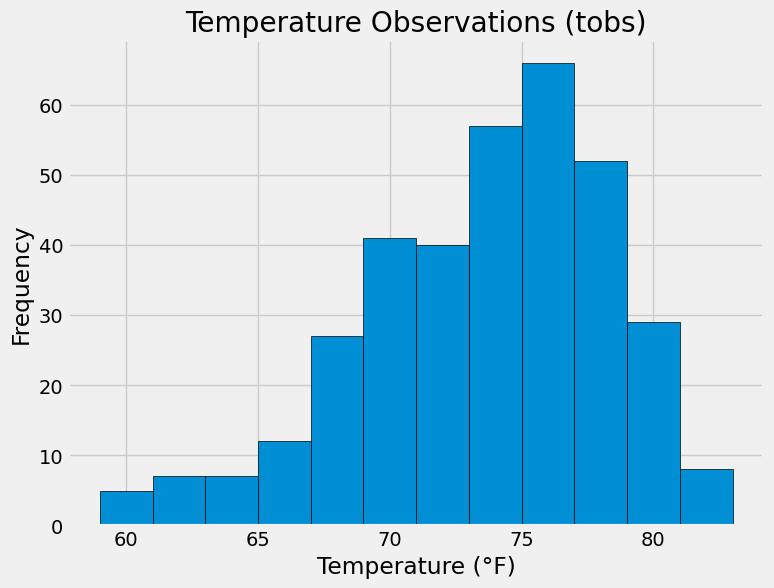

In [76]:
# Determine the most active station
most_active_station = session.query(Measurement.station)\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.station).desc())\
    .first()

# Calculate the date 12 months ago
most_recent_date = session.query(Measurement.date)\
    .order_by(Measurement.date.desc())\
    .first()

# Find the most recent date and a date one year prior
most_recent_date = dt.strptime(most_recent_date[0], "%Y-%m-%d")
one_year_ago = most_recent_date - timedelta(days=365)

# Query the last 12 months of temperature observation (tobs) data for the most active station
temperature_results = session.query(Measurement.date, Measurement.tobs)\
    .filter(Measurement.station == most_active_station[0])\
    .filter(Measurement.date >= one_year_ago)\
    .order_by(Measurement.date.desc())\
    .all()

# Create a DataFrame from the query results
df_station_analysis = pd.DataFrame(temperature_results, columns=['date', 'tobs'])

# Plot the results as a histogram
plt.figure(figsize=(8, 6))
plt.hist(df_station_analysis['tobs'], bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations (tobs)')
plt.grid(True)
plt.show()


# Close session

In [77]:
# Close Session
session.close()